<a href="https://colab.research.google.com/github/ritwikkarthikeya/Fundamental/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [18]:
!kaggle datasets download -d arashnic/faces-age-detection-dataset

! unzip "faces-age-detection-dataset"


Streaming output truncated to the last 5000 lines.
  inflating: faces/Train/7917.jpg    
  inflating: faces/Train/7918.jpg    
  inflating: faces/Train/7919.jpg    
  inflating: faces/Train/792.jpg     
  inflating: faces/Train/7921.jpg    
  inflating: faces/Train/7922.jpg    
  inflating: faces/Train/7925.jpg    
  inflating: faces/Train/7926.jpg    
  inflating: faces/Train/7927.jpg    
  inflating: faces/Train/7928.jpg    
  inflating: faces/Train/793.jpg     
  inflating: faces/Train/7930.jpg    
  inflating: faces/Train/7931.jpg    
  inflating: faces/Train/7935.jpg    
  inflating: faces/Train/7936.jpg    
  inflating: faces/Train/7937.jpg    
  inflating: faces/Train/7938.jpg    
  inflating: faces/Train/794.jpg     
  inflating: faces/Train/7940.jpg    
  inflating: faces/Train/7941.jpg    
  inflating: faces/Train/7943.jpg    
  inflating: faces/Train/7944.jpg    
  inflating: faces/Train/7946.jpg    
  inflating: faces/Train/7947.jpg    
  inflating: faces/Train/7948.jpg    

In [19]:
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

In [20]:
data = pd.read_csv("/content/faces/train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [21]:
directory = "/content/faces/Train/"
data['filepath'] = directory + data['ID']

# Create DataFrame from the data
df_train = data[['filepath', 'Class']].rename(columns={'Class': 'label'})

# Check class distribution before splitting
print("Class distribution before splitting:")
print(df_train['label'].value_counts())

Class distribution before splitting:
label
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%) sets
train_df, dummy_df = train_test_split(df_train, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

# Print the shapes of the datasets
print(f"The shape of the Train data is: {train_df.shape}")
print(f"The shape of the Validation data is: {valid_df.shape}")
print(f"The shape of the Test data is: {test_df.shape}")

# Check class distribution in train_df
print("Class distribution in the Train data:")
print(train_df['label'].value_counts())

The shape of the Train data is: (15924, 2)
The shape of the Validation data is: (1991, 2)
The shape of the Test data is: (1991, 2)
Class distribution in the Train data:
label
MIDDLE    8623
YOUNG     5376
OLD       1925
Name: count, dtype: int64


In [23]:
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 80

# Create data generators
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices to ensure they are correct
print("Class indices:", train_ds.class_indices)


Training Data
Found 15924 validated image filenames belonging to 3 classes.
Validation Data
Found 1991 validated image filenames belonging to 3 classes.
Test Data
Found 1991 validated image filenames belonging to 3 classes.
Class indices: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


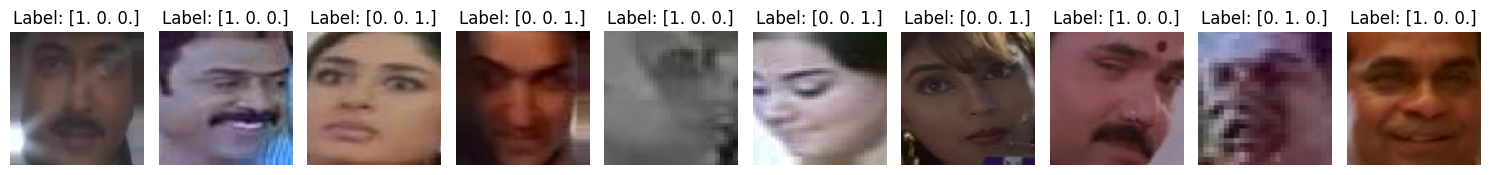

In [25]:
def display_random_images(generator, num_images):
    # Get batch of images and labels
    batch = next(generator)

    # Select random images from the batch
    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Assuming train_generator is your NumpyArrayIterator for the training set
# Display 5 random images from the training set
display_random_images(train_ds, 10)

In [26]:
  class_labels = train_ds.class_indices

  # Print the class labels
  print(f'Class labels: {class_labels}')

Class labels: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


In [27]:
from tensorflow.keras.applications import Xception

model = Sequential()
conv_base = Xception (
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

# Base Model
model.add(conv_base)

# Add Global Average Pooling to flatten the output from the base model
model.add(GlobalAveragePooling2D())

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Dense Layer 2
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer (number of classes should match your dataset)
model.add(Dense(3, activation='softmax'))  # Change the number of units to match the number of classes

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

#callback to stop training when accuracy exceeds 93%
class AccuracyStopCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.93):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        if accuracy is not None and accuracy >= self.target_accuracy:
            print(f"Accuracy reached {self.target_accuracy * 100}%. Stopping training.")
            self.model.stop_training = True

accuracy_stop = AccuracyStopCallback(target_accuracy=0.93)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with both callbacks
history = model.fit(
    train_ds,  # Your training dataset
    epochs=40,  # Maximum number of epochs
    validation_data=validation_ds,  # Your validation dataset
    callbacks=[early_stopping, accuracy_stop]  # Use both EarlyStopping and AccuracyStopCallback
)

Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8584 - loss: 0.4230 - val_accuracy: 0.7991 - val_loss: 0.6106
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8774 - loss: 0.4341 - val_accuracy: 0.8172 - val_loss: 0.5662
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8909 - loss: 0.3622 - val_accuracy: 0.8066 - val_loss: 0.6958
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9146 - loss: 0.2950 - val_accuracy: 0.7951 - val_loss: 0.7620
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9135 - loss: 0.3627 - val_accuracy: 0.7579 - val_loss: 0.6180
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9126 - loss: 0.2961 - val_accuracy: 0.7614 - val_loss: 4.1136
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9116 - loss: 0.3119 - val_accuracy: 0.7921 - val_loss: 0.6575
Epoch 7: early stopping


In [39]:
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy:', accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - accuracy: 0.8120 - loss: 0.6235
Test accuracy: 0.7920643091201782


In [40]:
pred = model.predict(test_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step


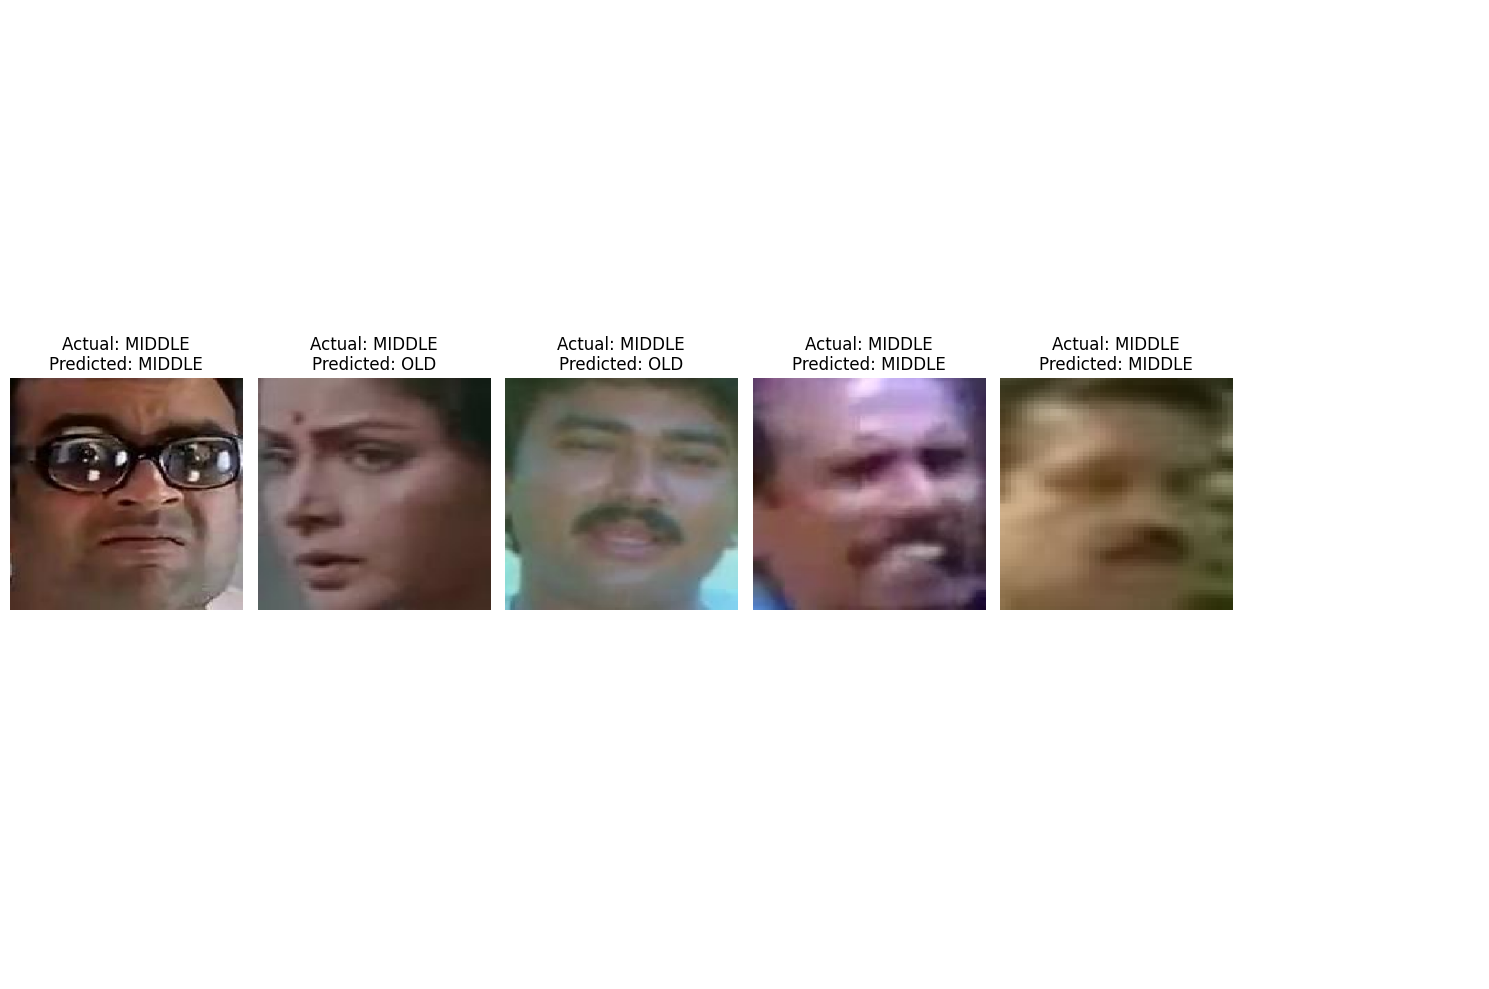

In [41]:
num_images_to_display = 5

# Fetch a batch of test data from the test dataset generator (test_ds)
x_test, y_test = next(iter(test_ds))
x_test = x_test[:num_images_to_display]
y_test = y_test[:num_images_to_display]

# Get predictions for the batch of test images
pred = model.predict(test_ds)
pred_classes = np.argmax(pred, axis=1)

# Define class names
classes = ['MIDDLE','YOUNG','OLD']

# Number of columns for the subplot grid
num_columns = 6
num_rows = (num_images_to_display + num_columns - 1) // num_columns

# Plot the images with actual and predicted labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(x_test):
        ax.imshow(x_test[i])
        actual_label = classes[np.argmax(y_test[i])]  # Convert one-hot to index
        predicted_label = classes[pred_classes[i]]
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

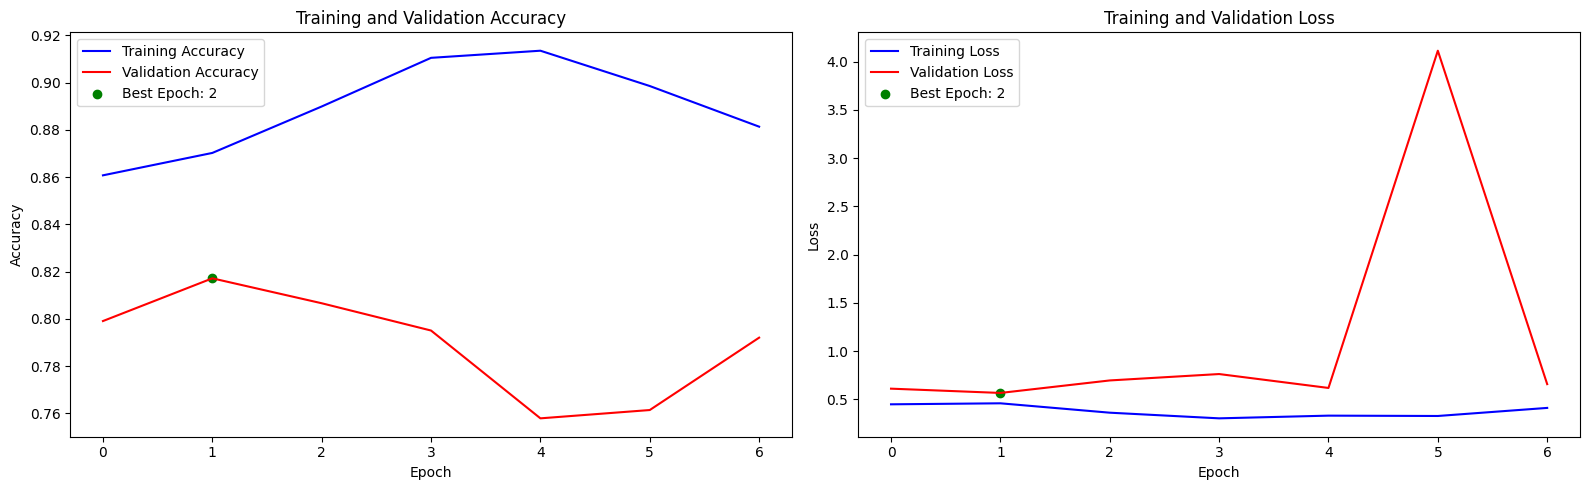

In [42]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1



# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [43]:
import tensorflow as tf


model.save("my_model.keras")

Saving pic1.jpg to pic1 (3).jpg


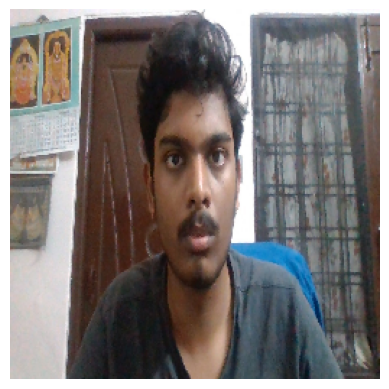

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: YOUNG


In [61]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Step 1: Upload the image using Google Colab's file uploader
uploaded = files.upload()

# Step 2: Load the uploaded image
img_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
img = load_img(img_path, target_size=(256, 256))  # Resize image to (256, 256) to match your model's input size

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Step 3: Convert image to array
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the image to match the model's input format
img_array = preprocess_input(img_array)

# Step 4: Load your pre-trained model
model = load_model('/content/my_model.keras')

# Step 5: Predict the class of the uploaded image
classes = [ 'YOUNG','MIDDLE', 'OLD']  # Define the classes
pred = model.predict(img_array)  # Get the prediction
predicted_class = classes[np.argmax(pred)]  # Get the class with the highest probability

# Output the predicted class
print(f"Predicted Class: {predicted_class}")


Saving pic6.jpg to pic6.jpg


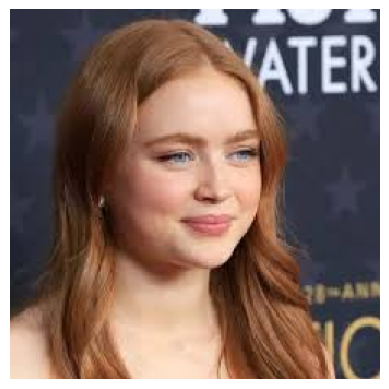

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: YOUNG


In [60]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Step 1: Upload the image using Google Colab's file uploader
uploaded = files.upload()

# Step 2: Load the uploaded image
img_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
img = load_img(img_path, target_size=(256, 256))  # Resize image to (256, 256) to match your model's input size

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Step 3: Convert image to array
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the image to match the model's input format
img_array = preprocess_input(img_array)

# Step 4: Load your pre-trained model
model = load_model('/content/my_model.keras')

# Step 5: Predict the class of the uploaded image
classes = [ 'YOUNG','MIDDLE', 'OLD']  # Define the classes
pred = model.predict(img_array)  # Get the prediction
predicted_class = classes[np.argmax(pred)]  # Get the class with the highest probability

# Output the predicted class
print(f"Predicted Class: {predicted_class}")


Saving pic7.jpg to pic7 (1).jpg


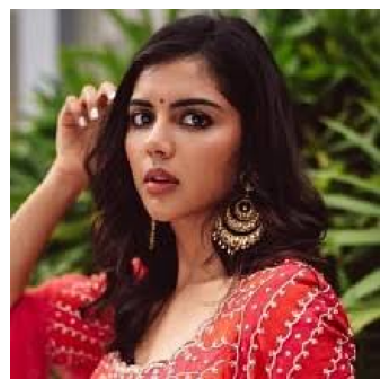

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: MIDDLE


In [63]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Step 1: Upload the image using Google Colab's file uploader
uploaded = files.upload()

# Step 2: Load the uploaded image
img_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
img = load_img(img_path, target_size=(256, 256))  # Resize image to (256, 256) to match your model's input size

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Step 3: Convert image to array
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the image to match the model's input format
img_array = preprocess_input(img_array)

# Step 4: Load your pre-trained model
model = load_model('/content/my_model.keras')

# Step 5: Predict the class of the uploaded image
classes = ['MIDDLE','YOUNG', 'OLD']  # Define the classes
pred = model.predict(img_array)  # Get the prediction
predicted_class = classes[np.argmax(pred)]  # Get the class with the highest probability

# Output the predicted class
print(f"Predicted Class: {predicted_class}")


Saving pic3.jpg to pic3.jpg


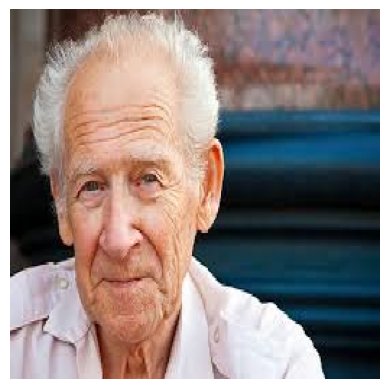

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: MIDDLE


In [64]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Step 1: Upload the image using Google Colab's file uploader
uploaded = files.upload()

# Step 2: Load the uploaded image
img_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
img = load_img(img_path, target_size=(256, 256))  # Resize image to (256, 256) to match your model's input size

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Step 3: Convert image to array
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the image to match the model's input format
img_array = preprocess_input(img_array)

# Step 4: Load your pre-trained model
model = load_model('/content/my_model.keras')

# Step 5: Predict the class of the uploaded image
classes = ['MIDDLE','YOUNG', 'OLD']
pred = model.predict(img_array)  # Get the prediction
predicted_class = classes[np.argmax(pred)]  # Get the class with the highest probability

# Output the predicted class
print(f"Predicted Class: {predicted_class}")
